# Regression model—biophony

This notebook explores and models the data collected from recordings of the natural acoustic environment over the urban-rural gradient near Innsbruck, Austria. The models are implemented as Bayesian models with the PyMC3 probabilistic programming library.

References:<br />
https://github.com/fonnesbeck/multilevel_modeling<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

#### Import statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import numpy
from os import path

In [3]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import seaborn
import mpld3
from mpld3 import plugins

In [4]:
from pymc3 import glm, Model, NUTS, sample, stats, \
                  forestplot, traceplot, plot_posterior, summary, \
                  Normal, Uniform, Deterministic, StudentT
from pymc3.backends import SQLite

#### Plot settings

In [5]:
from matplotlib import rcParams

In [6]:
rcParams['font.sans-serif']

['Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

In [7]:
rcParams['font.sans-serif'] = ['Helvetica',
                               'Arial',
                               'Bitstream Vera Sans',
                               'DejaVu Sans',
                               'Lucida Grande',
                               'Verdana',
                               'Geneva',
                               'Lucid',
                               'Avant Garde',
                               'sans-serif']

#### Variable definitions

In [8]:
data_filepath = "/Users/Jake/OneDrive/Documents/alpine soundscapes/data/dataset.csv"

In [9]:
trace_output_path = "/Users/Jake/OneDrive/Documents/alpine soundscapes/data/model traces/biophony"

In [10]:
seaborn_blue = seaborn.color_palette()[0]

## Load data

In [11]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

sort data by site and then by visit

In [12]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

create composite land cover variable

In [13]:
data_sorted['land_composite_50m'] = data_sorted.forest_50m - (data_sorted.building_50m + data_sorted.pavement_50m)
data_sorted['land_composite_100m'] = data_sorted.forest_100m - (data_sorted.building_100m + data_sorted.pavement_100m)
data_sorted['land_composite_200m'] = data_sorted.forest_200m - (data_sorted.building_200m + data_sorted.pavement_200m)
data_sorted['land_composite_500m'] = data_sorted.forest_500m - (data_sorted.building_500m + data_sorted.pavement_500m)

transform variables (mean center)

In [14]:
column_list = ['sel', 'sel_anthrophony', 'sel_biophony', 'biophony', 'week', 
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m',
    'temperature', 'wind_speed', 'pressure', 'bus_stop',
    'construction', 'crossing', 'cycleway', 'elevator', 'escape', 'footway',
    'living_street', 'motorway', 'motorway_link', 'path', 'pedestrian',
    'platform', 'primary_road', 'primary_link', 'proposed', 'residential',
    'rest_area', 'secondary', 'secondary_link', 'service', 'services',
    'steps', 'tertiary', 'tertiary_link', 'track', 'unclassified', 'combo']

data_centered = data_sorted.copy()
for column in column_list:
    data_centered[column] = data_sorted[column] - data_sorted[column].mean()

create sites variable for PyMC3 models

In [15]:
sites = numpy.copy(data_sorted.site.values) - 1

## Model 0 - emtpy model

$$
\begin{align}
y_{ts} \sim \mathcal{N}(\alpha_s + \epsilon_t, \sigma_y^2) \\
\alpha_s \sim \mathcal{N}(M + \epsilon_s, \sigma_\alpha^2) \\
\end{align}
$$

In [16]:
with Model() as model0:
    
    # Priors
    mu_grand = Normal('mu_grand', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_grand, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)
    
    # sample model
    backend = SQLite(path.join(trace_output_path, "model0.sqlite"))
    model0_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

100%|██████████| 10000/10000 [00:32<00:00, 310.13it/s]


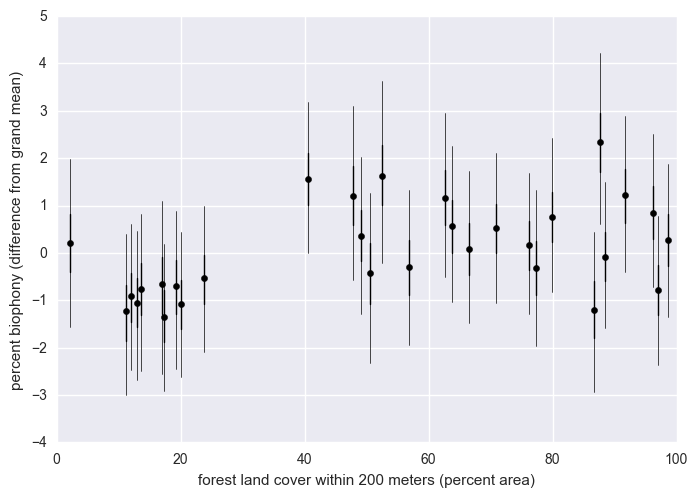

In [17]:
fig, ax = pyplot.subplots()

# organize results
model0_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model0_data['forest_200m'] = data_sorted.forest_200m.unique()
model0_data['quantiles'] = [stats.quantiles(model0_samples.a[:5000, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model0_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 100])
xl = ax.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax.set_ylabel("percent biophony (difference from grand mean)")

## Model 1—time and site predictors

$$
\begin{align}
\text{level 1} \\
y_{ts} \sim \mathcal{N}(\alpha_s + \beta_s T_t, \sigma_y^2) \\
\text{level 2} \\
\alpha_s \sim \mathcal{N}(\gamma_\alpha + \gamma_{\alpha s} L_s, \sigma_\alpha^2) \\
\beta_s \sim \mathcal{N}(\gamma_\beta + \gamma_{\beta s} L_s, \sigma_\beta^2) \\
\end{align}
$$

In [18]:
site_predictors = [
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m',
]
for predictor in site_predictors:
    with Model() as model_1:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')[predictor].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')[predictor].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week)

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = SQLite(path.join(trace_output_path, "model1_{}.sqlite".format(predictor)))
        model_1_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

100%|██████████| 10000/10000 [06:16<00:00, 26.58it/s]


In [26]:
len(model_1_samples['a'][:5000][:,1])

5000

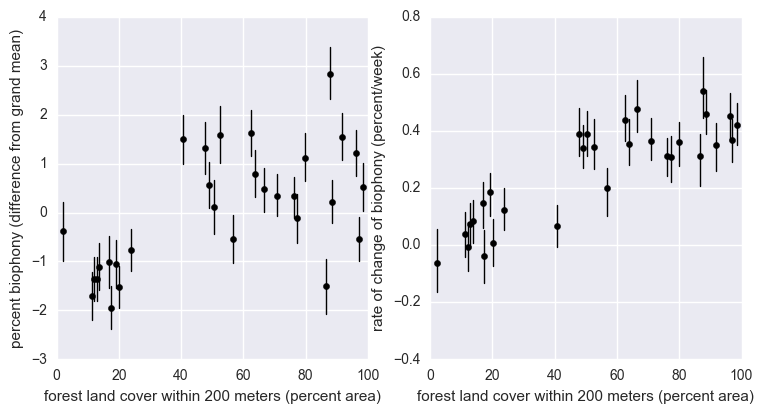

In [27]:
fig = pyplot.figure()

fig.set_figwidth(6.85)
fig.set_figheight(6.85/2)

ax_a = pyplot.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
ax_b = pyplot.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1, sharex=ax_a)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1)

# organize results
model_1_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model_1_data['forest_200m'] = data_sorted.forest_200m.unique()
model_1_data['quantiles_a'] = [stats.quantiles(model_1_samples['a'][:5000][:, i]) for i in range(len(set(sites)))]
model_1_data['quantiles_b'] = [stats.quantiles(model_1_samples['b'][:5000][:, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model_1_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    #ax_a.plot([x, x], [row['quantiles_a'][2.5], row['quantiles_a'][97.5]], color='black', linewidth=0.5)
    ax_a.plot([x, x], [row['quantiles_a'][25], row['quantiles_a'][75]], color='black', linewidth=1)
    ax_a.scatter([x], [row['quantiles_a'][50]], color='black', marker='o')

# format plot
l1 = ax_a.set_xlim([0, 100])
xl = ax_a.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax_a.set_ylabel("percent biophony (difference from grand mean)")

# plot quantiles
for i, row in model_1_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    #ax_b.plot([x, x], [row['quantiles_b'][2.5], row['quantiles_b'][97.5]], color='black', linewidth=0.5)
    ax_b.plot([x, x], [row['quantiles_b'][25], row['quantiles_b'][75]], color='black', linewidth=1)
    ax_b.scatter([x], [row['quantiles_b'][50]], color='black', marker='o')

# format plot
l1 = ax_b.set_xlim([0, 100])
xl = ax_b.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax_b.set_ylabel("rate of change of biophony (percent/week)")

## Model 2—environmental predictors

$$
\begin{align}
\text{level 1} \\
y_{ts} \sim \mathcal{N}(\alpha_s + \beta_s T_t, \sigma_y^2) \\
\text{level 2} \\
\alpha_s \sim \mathcal{N}(\gamma_\alpha + \gamma_{\alpha s} L_s, \sigma_\alpha^2) \\
\beta_s \sim \mathcal{N}(\gamma_\beta + \gamma_{\beta s} L_s, \sigma_\beta^2) \\
\end{align}
$$

In [28]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure',
]
for predictor in measurement_predictors:
    with Model() as model2a:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # temp slope
        #g_c = Normal('g_c', mu=0, tau=0.001)
        #g_cs = Normal('g_cs', mu=0, tau=0.001)
        #sigma_c = Uniform('sigma_c', lower=0, upper=100)
        #tau_c = sigma_c**-2
        #mu_c = g_c + (g_cs * data_centered.groupby('site')['forest_200m'].mean())
        #c = Normal('c', mu=mu_c, tau=tau_c, shape=len(set(sites)))
        c = Uniform('c', lower=-100, upper=100)

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week) + (c * data_centered[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = SQLite(path.join(trace_output_path, "model2a_{0}.sqlite".format(predictor)))
        model_2_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

100%|██████████| 10000/10000 [05:27<00:00, 30.53it/s]


In [29]:
measurement_predictors = [
    'temperature', 'wind_speed', 'precipitation', 'pressure',
]
for predictor in measurement_predictors:
    with Model() as model2b:

        # intercept
        g_a = Normal('g_a', mu=0, tau=0.001)
        g_as = Normal('g_as', mu=0, tau=0.001)
        sigma_a = Uniform('sigma_a', lower=0, upper=100)
        tau_a = sigma_a**-2
        mu_a = g_a + (g_as * data_centered.groupby('site')['forest_200m'].mean())
        a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

        # time slope
        g_b = Normal('g_b', mu=0, tau=0.001)
        g_bs = Normal('g_bs', mu=0, tau=0.001)
        sigma_b = Uniform('sigma_b', lower=0, upper=100)
        tau_b = sigma_b**-2
        mu_b = g_b + (g_bs * data_centered.groupby('site')['forest_200m'].mean())
        b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

        # predictor slope
        g_c = Normal('g_c', mu=0, tau=0.001)
        g_cs = Normal('g_cs', mu=0, tau=0.001)
        sigma_c = Uniform('sigma_c', lower=0, upper=100)
        tau_c = sigma_c**-2
        mu_c = g_c + (g_cs * data_centered.groupby('site')['forest_200m'].mean())
        c = Normal('c', mu=mu_c, tau=tau_c, shape=len(set(sites)))

        # model error (data-level)
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        tau_y = sigma_y**-2

        # expected values
        y_hat = a[sites] + (b[sites] * data_centered.week) + (c[sites] * data_centered[predictor])

        # likelihood
        y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)

        # simulated
        #y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

        # sample model
        backend = SQLite(path.join(trace_output_path, "model2b_{0}.sqlite".format(predictor)))
        model_2_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

100%|██████████| 10000/10000 [12:17<00:00,  7.75it/s]


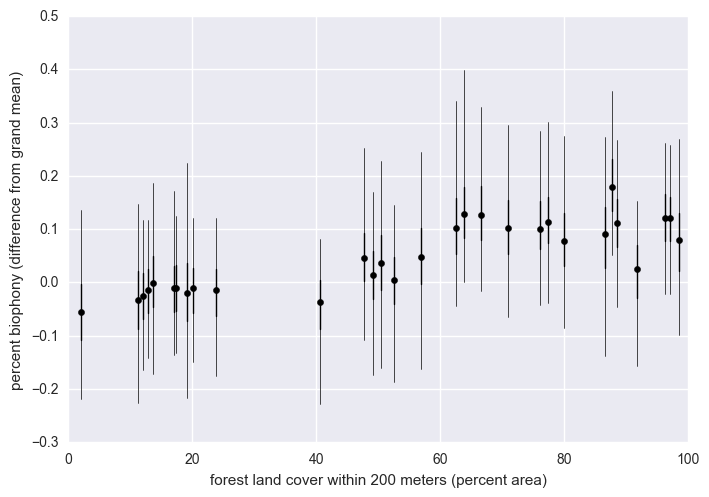

In [30]:
fig, ax = pyplot.subplots()

# organize results
model_2_data = pandas.DataFrame({'site': data_sorted.site.unique(), 
                                 'site_name': data_sorted.site_name.unique()})
model_2_data['forest_200m'] = data_sorted.forest_200m.unique()
model_2_data['quantiles'] = [stats.quantiles(model_2_samples['c'][:1000][:, i]) for i in range(len(set(sites)))]

# plot quantiles
for i, row in model_2_data.sort_values(by='forest_200m').iterrows():
    x = row['forest_200m']
    ax.plot([x, x], [row['quantiles'][2.5], row['quantiles'][97.5]], color='black', linewidth=0.5)
    ax.plot([x, x], [row['quantiles'][25], row['quantiles'][75]], color='black', linewidth=1)
    ax.scatter([x], [row['quantiles'][50]], color='black', marker='o')

# format plot
l1 = ax.set_xlim([0, 100])
xl = ax.set_xlabel("forest land cover within 200 meters (percent area)")
yl = ax.set_ylabel("percent biophony (difference from grand mean)")